### Задание 1. Прогнозирование метрик

Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-11-08 по 2023-11-14. Оценим эффективность этого мероприятия.

Для этого:
1. Решим, какие метрики должны были измениться во время флэшмоба и как.
2. Проверим, реально ли эти метрики изменились, используя CausalImpact. 
3. Выясним, имел ли флэшмоб какие-то долгосрочные эффекты.

### 1. Подготовка к работе

In [1]:
#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
import numpy as np
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from causalimpact import CausalImpact
import warnings
warnings.filterwarnings("ignore")


2023-12-13 18:22:08.026879: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 18:22:08.280503: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 18:22:08.282861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 18:22:10.102046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 2. Загрузка данных

In [2]:
#параметры соединения 
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231113',
'user':'student',
'password':'dpo_python_2020'
}

Об эффективности проведенного нашей компанией флэшмоба нам может рассказать рост активности нашей аудитории, значит должны были вырасти такие метрики, как среднее количество лайков, просмотров, количество уникальных пользователей за сутки, а также CTR и ER.

Изучим их изменения.


In [3]:
# запрос к данным
query = '''
SELECT 
    toStartOfDay(time) as date,
    count(DISTINCT user_id) AS dau,
    countIf(action = 'like') / COUNT(DISTINCT user_id) AS likes,
    countIf(action = 'view') / COUNT(DISTINCT user_id) AS views,
    countIf(action = 'like')/countIf(action = 'view') AS ctr,
    (countIf(user_id, action='like') + countIf(user_id, action='view'))/ COUNT(DISTINCT user_id) AS er
FROM 
    {db}.feed_actions
WHERE date >= '2023-10-25'
      AND date <= '2023-11-28'
GROUP BY date
ORDER BY date

'''

In [4]:
df = ph.read_clickhouse(query, connection=connection)
df.head()

,date,dau,likes,views,ctr,er
0,2023-10-25,12651,7.068927,33.238321,0.212674,40.307248
1,2023-10-26,12968,6.137107,29.551280,0.207677,35.688387
2,2023-10-27,13201,5.890539,27.743201,0.212324,33.633740
3,2023-10-28,13928,7.013785,32.941054,0.212919,39.954839
4,2023-10-29,14540,7.903714,37.799656,0.209095,45.703370


### 3. Анализ данных

#### 3.1 Проверка с помощью CausalImpact

Проведем проверку, действительно ли изменились метрики активности нашей аудитории с помощью пакета CausalImpact. 
Предскажем временной ряд, а затем посмотрим, насколько предсказания расходятся с реальными показателями после флэшмоба.

In [5]:
# выберем период для предсказания
pre_period = [pd.Timestamp ("2023-10-25"), pd.Timestamp("2023-11-07")]
post_period = [ pd.Timestamp("2023-11-08"),  pd.Timestamp("2023-11-14")]

#### DAU (количество уникальных пользователей за сутки)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-12-13 18:22:20.509949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-12-13 18:22:20.510604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-12-13 18:22:20.519951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-12-13 18:22:20.520223: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2023-12-13 18:22:21.568848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-13 18:22:21.589470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-13 18:22:21.620118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node monte_carlo_variational_loss/expectation/powerInv

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2023-12-13 18:22:33.345851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-12-13 18:22:33.415735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

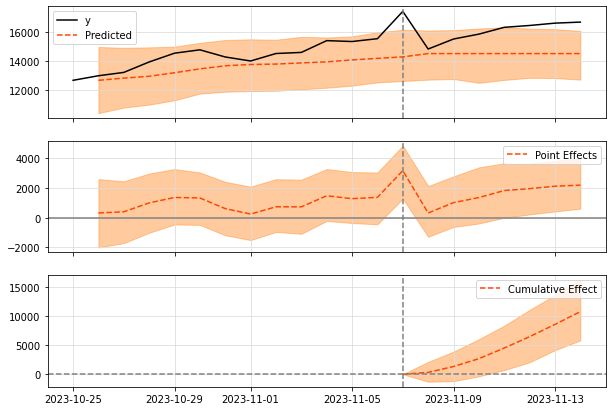

In [6]:
# применим метод
impact_dau = CausalImpact(df[['date', 'dau']].set_index('date'), 
                          pre_period, 
                          post_period)
# посмотрим результат

impact_dau.plot()

In [7]:
# выведем отчет

print(impact_dau.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         14511.28 (418.25)  101578.97 (2927.74)
95% CI                    [13703.28, 15342.78][95922.93, 107399.47]

Absolute effect (s.d.)    1541.43 (418.25)   10790.03 (2927.74)
95% CI                    [709.93, 2349.44]  [4969.53, 16446.07]

Relative effect (s.d.)    10.62% (2.88%)     10.62% (2.88%)
95% CI                    [4.89%, 16.19%]    [4.89%, 16.19%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [8]:
# для более детального отчета запустить
# print(impact_dau.summary('report'))

##### Вывод

Видим, что DAU действительно изменился за период проведения флэшмоба: без флэшмоба ожидалось, что DAU будет составлять 14511 пользователей в сутки, но он по итогу флэшмоба вырос на 10,63%.

Это означает, что положительный эффект на DAU, наблюдаемый в ходе проведения флэшмоба статистически значим и вряд ли вызван случайностью.

#### Cреднее количество просмотров на пользователя

2023-12-10 19:23:39.567082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:23:39.597486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:23:40.026644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:

2023-12-10 19:23:49.287216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-12-10 19:23:49.345895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

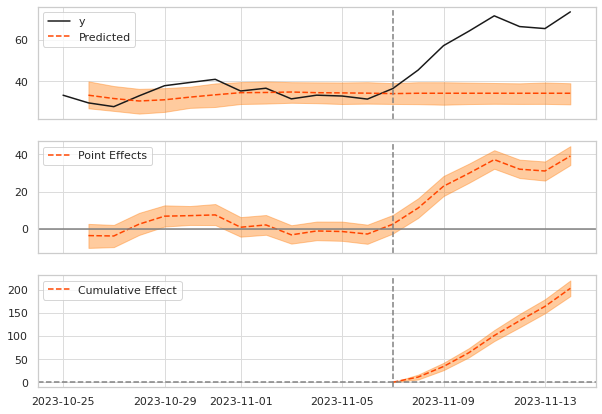

In [43]:
# применим метод
impact_views = CausalImpact(df[['date', 'views']].set_index('date'), 
                          pre_period, 
                          post_period)
# посмотрим результат

impact_views.plot()

In [44]:
print(impact_views.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    63.21              442.5
Prediction (s.d.)         34.18 (1.15)       239.24 (8.05)
95% CI                    [31.91, 36.42]     [223.37, 254.92]

Absolute effect (s.d.)    29.04 (1.15)       203.26 (8.05)
95% CI                    [26.8, 31.3]       [187.58, 219.13]

Relative effect (s.d.)    84.96% (3.36%)     84.96% (3.36%)
95% CI                    [78.41%, 91.6%]    [78.41%, 91.6%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [47]:
# для более детального отчета запустить
# print(impact_views.summary('report'))

##### Вывод
Здесь видим, что среднее количество просмотров на пользователя выросло на 84,96% за период проведения флэшмоба. Ожидалось, что без флэшмоба среднее количество просмотров будет равно 34.

Это означает, что положительный эффект на среднее количество просмотров, наблюдаемый в ходе проведения флэшмоба статистически значим и вряд ли вызван случайностью.

#### Cреднее количество лайков на пользователя

2023-12-10 19:18:31.325766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:18:31.345859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:18:31.749466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:

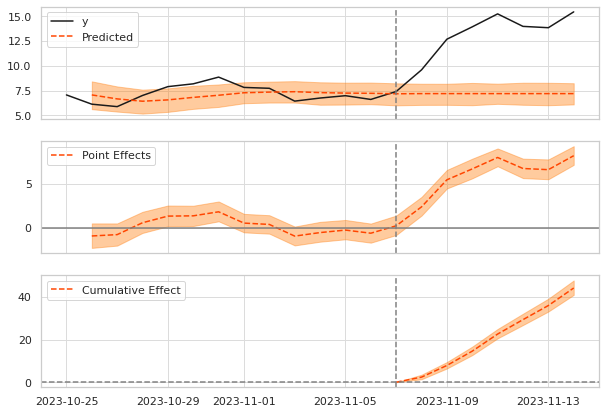

In [40]:
# применим метод
impact_likes = CausalImpact(df[['date', 'likes']].set_index('date'), 
                          pre_period, 
                          post_period)
# посмотрим результат

impact_likes.plot()

In [41]:
print(impact_likes.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    13.52              94.65
Prediction (s.d.)         7.2 (0.26)         50.4 (1.82)
95% CI                    [6.71, 7.72]       [46.94, 54.07]

Absolute effect (s.d.)    6.32 (0.26)        44.25 (1.82)
95% CI                    [5.8, 6.82]        [40.58, 47.71]

Relative effect (s.d.)    87.81% (3.61%)     87.81% (3.61%)
95% CI                    [80.52%, 94.67%]   [80.52%, 94.67%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [50]:
# для более детального отчета запустить
# print(impact_likes.summary('report'))

##### Вывод
Среднее количество лайков на пользователя выросло почти так же, как и среднее количество просмотров - на 87,81% за период проведения флэшмоба. Ожидалось, что без флэшмоба среднее количество лайков будет равно 7.

Это означает, что положительный эффект на среднее количество лайков, наблюдаемый в ходе проведения флэшмоба статистически значим и вряд ли вызван случайностью.

#### CTR (кликабельность)

2023-12-10 19:29:33.280156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:29:33.298709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:29:33.762507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:

2023-12-10 19:29:43.381444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-12-10 19:29:43.438095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

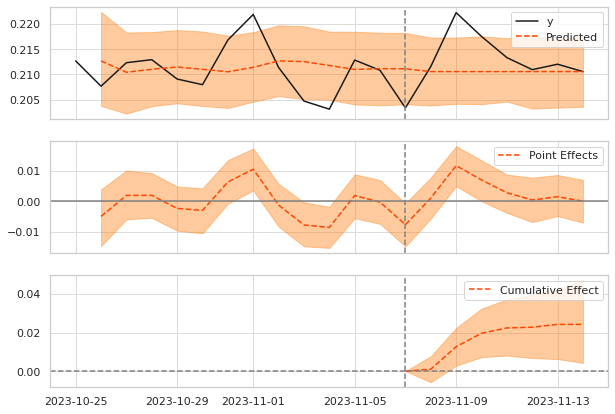

In [52]:
# применим метод
impact_ctr = CausalImpact(df[['date', 'ctr']].set_index('date'), 
                          pre_period, 
                          post_period)
# посмотрим результат

impact_ctr.plot()

In [53]:
print(impact_ctr.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.47 (0.01)
95% CI                    [0.21, 0.21]       [1.45, 1.5]

Absolute effect (s.d.)    0.0 (0.0)          0.02 (0.01)
95% CI                    [0.0, 0.01]        [0.0, 0.04]

Relative effect (s.d.)    1.64% (0.73%)      1.64% (0.73%)
95% CI                    [0.18%, 3.04%]     [0.18%, 3.04%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 99.1%

For more details run the command: print(impact.summary('report'))


In [55]:
# для более детального отчета запустить
# print(impact_ctr.summary('report'))

##### Вывод

Эффект от проведения флэшмоба на CTR составил малозначительное увеличение на 1.64%, что хорошо видим и на графике.

#### ER (показатель вовлеченности пользователей)

2023-12-10 19:35:49.725297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:35:49.743488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:35:50.152297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:

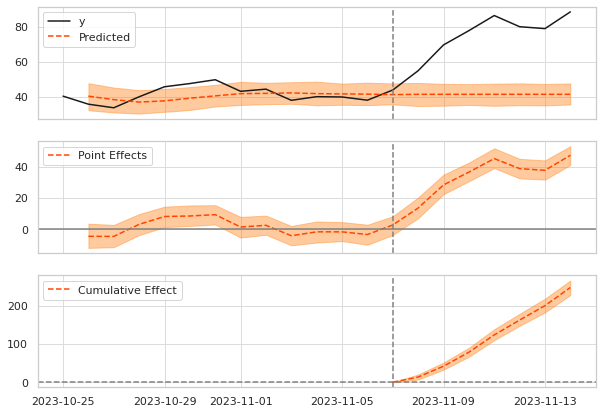

In [57]:
# применим метод
impact_er = CausalImpact(df[['date', 'er']].set_index('date'), 
                          pre_period, 
                          post_period)
# посмотрим результат

impact_er.plot()

In [58]:
print(impact_er.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    76.74              537.15
Prediction (s.d.)         41.38 (1.38)       289.64 (9.63)
95% CI                    [38.72, 44.11]     [271.01, 308.75]

Absolute effect (s.d.)    35.36 (1.38)       247.51 (9.63)
95% CI                    [32.63, 38.02]     [228.4, 266.14]

Relative effect (s.d.)    85.46% (3.32%)     85.46% (3.32%)
95% CI                    [78.86%, 91.89%]   [78.86%, 91.89%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [76]:
# для более детального отчета запустить
# print(impact_er.summary('report'))

##### Вывод
Вовлеченность пользователей выросла почти так же, как и среднее количество просмотров и среднее колиество лайков - на 85,46% за период проведения флэшмоба. Ожидалось, что без флэшмоба ER будет равен 41.38.

Это означает, что положительный эффект на ER, наблюдаемый в ходе проведения флэшмоба статистически значим и вряд ли вызван случайностью.

#### Выводы по проверке

По итогам проверки эффекта флэшмоба на исследуемые нами метрики можно сказать, что большинство метрик показывают значительный рост за время проведения флэшмоба за исключением CTR.
Этот показатель увеличился лишь на 1.64%.

Проверим также с помощью CausalImpact, имел ли флэшмоб какие-то долгосрочные эффекты на анализируемые метрики.

_________________

#### 3.2 Проверка с помощью CausalImpact долгосрочного влияния

Для исследования долгосрочного влияния флешмоба сравним прогноз на основе данных перед флешмобом с данными во время и после флешмоба.

In [79]:
# зададим новые периоды для предсказания
pre_period = [pd.Timestamp ("2023-10-25"), pd.Timestamp("2023-11-07")]
post_period_2 = [ pd.Timestamp("2023-11-08"),  pd.Timestamp("2023-11-25")]

2023-12-10 19:55:20.170689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:55:20.189711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:55:20.610365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:

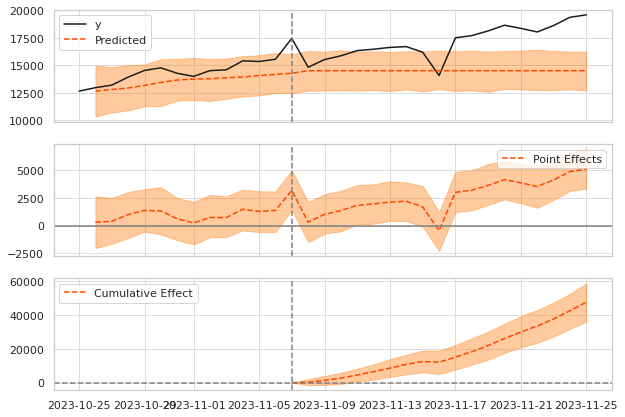

In [80]:
# применим метод
impact_dau2 = CausalImpact(df[['date', 'dau']].set_index('date'), 
                          pre_period, 
                          post_period_2)
# посмотрим результат

impact_dau2.plot()

2023-12-10 19:55:44.925021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:55:44.945621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:55:46.081849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:

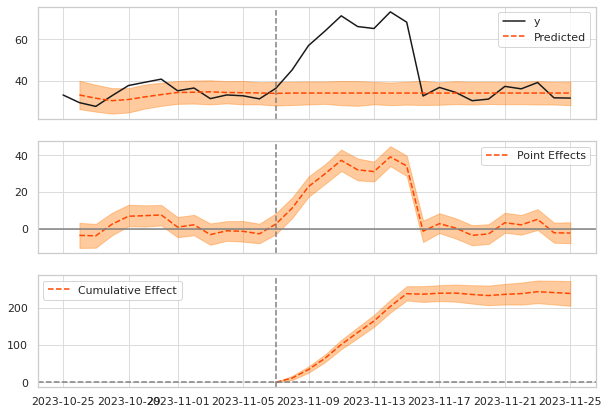

In [81]:
# применим метод
impact_views2 = CausalImpact(df[['date', 'views']].set_index('date'), 
                          pre_period, 
                          post_period_2)
# посмотрим результат

impact_views2.plot()

2023-12-10 19:55:57.954180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:55:57.972447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:55:58.382996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:

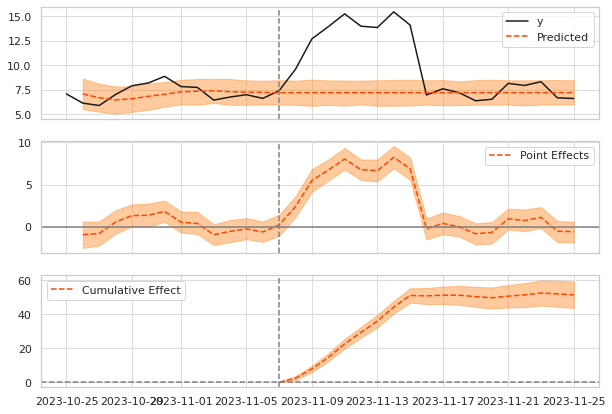

In [82]:
# применим метод
impact_likes2 = CausalImpact(df[['date', 'likes']].set_index('date'), 
                          pre_period, 
                          post_period_2)
# посмотрим результат

impact_likes2.plot()

2023-12-10 19:59:26.659698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:59:26.689552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:59:27.154603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 19:

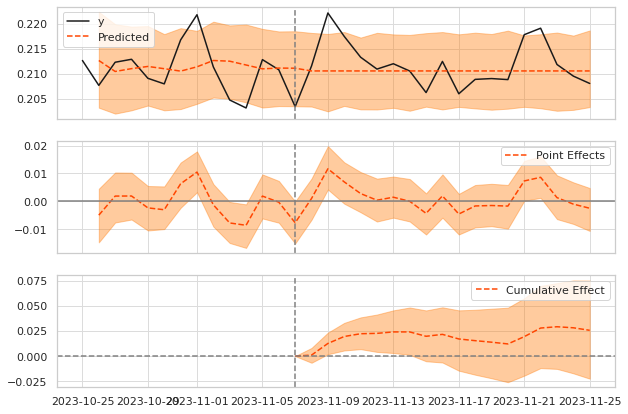

In [88]:
# применим метод
impact_ctr2 = CausalImpact(df[['date', 'ctr']].set_index('date'), 
                          pre_period, 
                          post_period_2)
# посмотрим результат

impact_ctr2.plot()

2023-12-10 20:00:36.670830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 20:00:36.689840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 20:00:37.100891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-12-10 20:

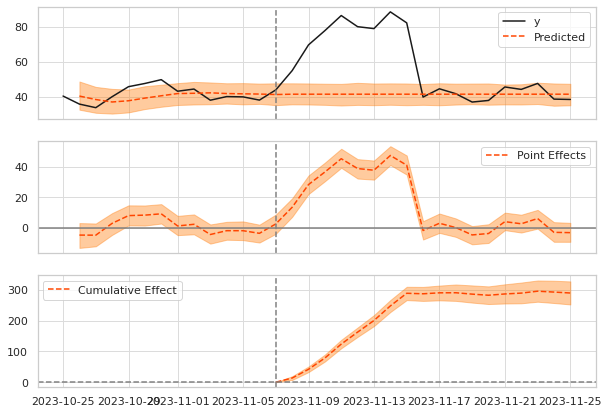

In [90]:
# применим метод
impact_er2 = CausalImpact(df[['date', 'er']].set_index('date'), 
                          pre_period, 
                          post_period_2)
# посмотрим результат

impact_er2.plot()

##### Вывод

Использованный нами метод CausalImpact дает нам сделать вывод, что в долгосрочном периоде после проведения флэшмоба исследуемые нами метрики расти не будут, за исключением DAU. Но рост одного показателя DAU говорит нам только о количественном росте  нашей аудитории. Для нас важнее качественная активность нашей аудитории, то есть рост среднего количества просмотров, лайков, CTR и ER.

_________________

#### Общие выводы

Итак, нами была исследована эффективность проведенного в ноябре 2023 г. флэшмоба для наших пользователей.
Для оценки эффективности были проанализированы изменения метрик: среднее количество лайков, просмотров, количество уникальных пользователей за сутки, а также CTR и ER.

Использованный нами метод CausalImpact позволяет сделать вывод, что большинство данных метрик показывают значительный рост за время проведения флэшмоба за исключением CTR. Этот показатель увеличился лишь на 1.64%. Метод дает нам возможность утверждать, что положительный эффект на исследуемые метрики, наблюдаемый в ходе проведения флэшмоба статистически значим и вряд ли вызван случайностью.

Также нами было выяснено, что в долгосрочном периоде после проведения флэшмоба данные метрики расти не будут, за исключением DAU. Но рост одного показателя DAU говорит нам только о количественном росте нашей аудитории,а для нас важнее качественная активность нашей аудитории, то есть рост среднего количества просмотров, лайков, CTR и ER.

Таким образом, в дальнейшнем стоит подумать об удержании такой же вовлеченности пользователей и после проведения флэшмоба. 